# Trabalho Final - Deep Learning and Reinforcement Learning

### Integrantes:

###    1) Jurandir Ventura - RM336634
###    2) Marcelo Preto - RM336632
###    3) Fabio Rizzi - RM336656
###    4) Thiago Alexandre – RM336583

## Redes Neurais Convolucionais

## Exercício #6.2 - 1 PONTO
### Utilizando o exemplo “Exemplo CNN Dataset CIFAR10.py” aumente a taxa de acerto atual (que em cerca de 60%) em ao menos 18% (totalizando 78-80% de acerto aproximadamente) calibrando a CNN.

### Dicas:
- Tente alterar a quantidade de épocas;
- Tente alterar o tamanho do batch_size;
- Tente alterar o tamanho dos filtros convolucionais;
- Cuidado para não gerar um conjunto de filtros inválidos
- Tente alterar a função de ativação na camada completamente conectada.
- Aplique os pré-processamentos necessários.
- Apresente a evolução do conjunto de treino e validação.
- Apresente a acurácia do conjunto de testes.
- Apresente a configuração (estrutura) da rede neural.

In [1]:
import keras
from keras.datasets import cifar10
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential,load_model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,BatchNormalization
from keras.utils import np_utils
from keras.utils import plot_model
import tensorflow as tf

In [2]:
print(tf.compat.v2.test.is_gpu_available)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

#carregando o dataset pré-embaralhado de treinamento bem como os dados de teste
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

<function is_gpu_available at 0x7f71b395c8b0>
Num GPUs Available:  1


Train: X=(50000, 32, 32, 3), y=(50000, 1)
Test: X=(10000, 32, 32, 3), y=(10000, 1)


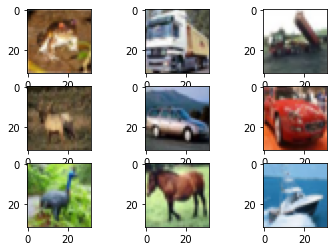

In [3]:
print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (x_test.shape, y_test.shape))
# plot first few images
for i in range(9):
	# define subplot
	plt.subplot(330 + 1 + i)
	# plot raw pixel data
	plt.imshow(x_train[i])
# show the figure
plt.show()

### 3. Redimensionando as imagens e dividindo cada pixel em cada imagem por 255

In [4]:
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

### 4.  Dividindo o dataset em treinamento, teste e validação

In [5]:
# "one-hot encode" aplicado aos rótulos
num_classes = len(np.unique(y_train))
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# divindo dataset de treinamento em treinamento, teste e validação - Apenas para exemplo em um ambiente real as amostras devem ser seleciondas de forma aleatória
(x_train, x_valid) = x_train[5000:], x_train[:5000]
(y_train, y_valid) = y_train[5000:], y_train[:5000]

# impressão da forma do conjunto de treino
print('x_train shape:', x_train.shape)

# impressão do número de imagens nos datasets de treinamento, teste e validação
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print(x_valid.shape[0], 'validation samples')

x_train shape: (45000, 32, 32, 3)
45000 train samples
10000 test samples
5000 validation samples


### 5. Definindo a arquitetura do modelo
 
 * 2 camadas convolucionais de tamanho progressivamente crescente
 * Máximo de camadas de "pooling" (2x2) seguidas por tais 3 camadas convolucionais
 * Uma camada do tipo totalmente conectada de 280 neurônios
 * Uma camada do tipo totalmente conectada de 120 neurônios
 * Últimas camadas do tipo totalmente conectadas de 10 saídas (10 classes de categoria de imagem)
 * "Dropout" de 0,2-0,3


In [6]:
model = Sequential()
#input_shape sem o parametro data_format='channels_first'
model.add(Conv2D(filters=32, kernel_size=6, padding='same', activation='relu', input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))

model.add(Conv2D(filters=64, kernel_size=10, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))

model.add(Flatten())

model.add(Dense(192, activation='elu'))
model.add(Dropout(0.2))
model.add(Dense(192, activation='elu'))
model.add(Dropout(0.3))
model.add(Dense(192, activation='elu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='elu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation='softmax'))

# tentem com outras funções de ativação (como visto em nossa Aula 3)
# mais informações em https://keras.io/activations/
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        3488      
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        204864    
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0

### 6. Compilando o modelo

Compilando o modelo escolhendo como se dará nossa perda, otimização e métricas (parâmetros do Keras)

Mais informações em https://keras.io/losses/ https://keras.io/optimizers/ https://keras.io/metrics/

In [7]:
#opt = keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### 7. Treinando o modelo

In [8]:
from keras.callbacks import ModelCheckpoint   

#O keras passa a salvar o melhor modelo pela função de perda
checkpointer = ModelCheckpoint(filepath='modelocifar10FIAP.hdf5', verbose=1,  save_best_only=True, monitor='val_accuracy')
hist = model.fit(x_train, y_train, batch_size=32, epochs=100, validation_data=(x_valid, y_valid), callbacks=[checkpointer], verbose=1, shuffle=True)

8354
Epoch 00032: val_accuracy improved from 0.76500 to 0.76820, saving model to modelocifar10FIAP.hdf5
1407/1407 [==============================] - 8s 5ms/step - loss: 0.5336 - accuracy: 0.8354 - val_loss: 0.7800 - val_accuracy: 0.7682
Epoch 33/100
1403/1407 [============================>.] - ETA: 0s - loss: 0.5650 - accuracy: 0.8275
Epoch 00033: val_accuracy did not improve from 0.76820
1407/1407 [==============================] - 7s 5ms/step - loss: 0.5660 - accuracy: 0.8271 - val_loss: 1.6131 - val_accuracy: 0.4848
Epoch 34/100
1397/1407 [============================>.] - ETA: 0s - loss: 0.5405 - accuracy: 0.8318
Epoch 00034: val_accuracy did not improve from 0.76820
1407/1407 [==============================] - 7s 5ms/step - loss: 0.5406 - accuracy: 0.8318 - val_loss: 0.8290 - val_accuracy: 0.7540
Epoch 35/100
1404/1407 [============================>.] - ETA: 0s - loss: 0.5737 - accuracy: 0.8217
Epoch 00035: val_accuracy did not improve from 0.76820
1407/1407 [=====================

### 8. Carregando o modelo com a melhor precisão de validação

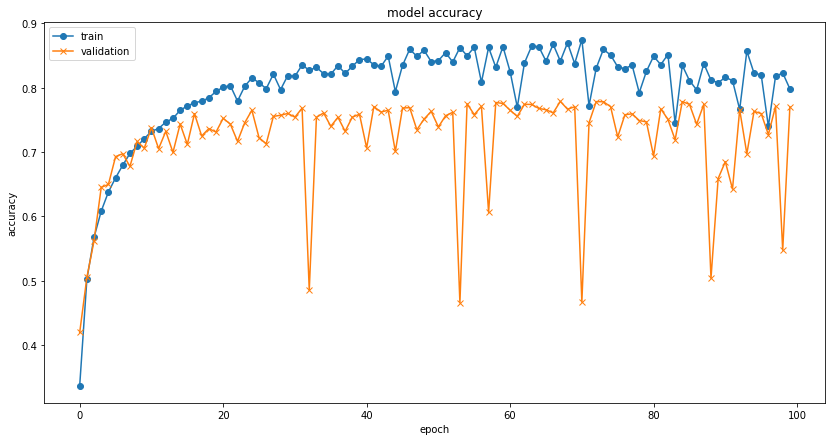

In [9]:
# carregando os pesos que geraram a melhor precisão de validação
model.load_weights('modelocifar10FIAP.hdf5')
model = load_model('modelocifar10FIAP.hdf5')
plt.figure(1,figsize=(14,7))
plt.plot(hist.history['accuracy'], 'o-')
plt.plot(hist.history['val_accuracy'], 'x-')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### 9. Cálculo da precisão de classificação no dataset de testes

In [10]:
# avaliar e imprimir a precisão do teste
score = model.evaluate(x_test, y_test, verbose=0)
print('\n', 'Test accuracy:', score[1])


 Test accuracy: 0.7645999789237976


### 10. Visualizar algumas predições

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        3488      
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        204864    
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0

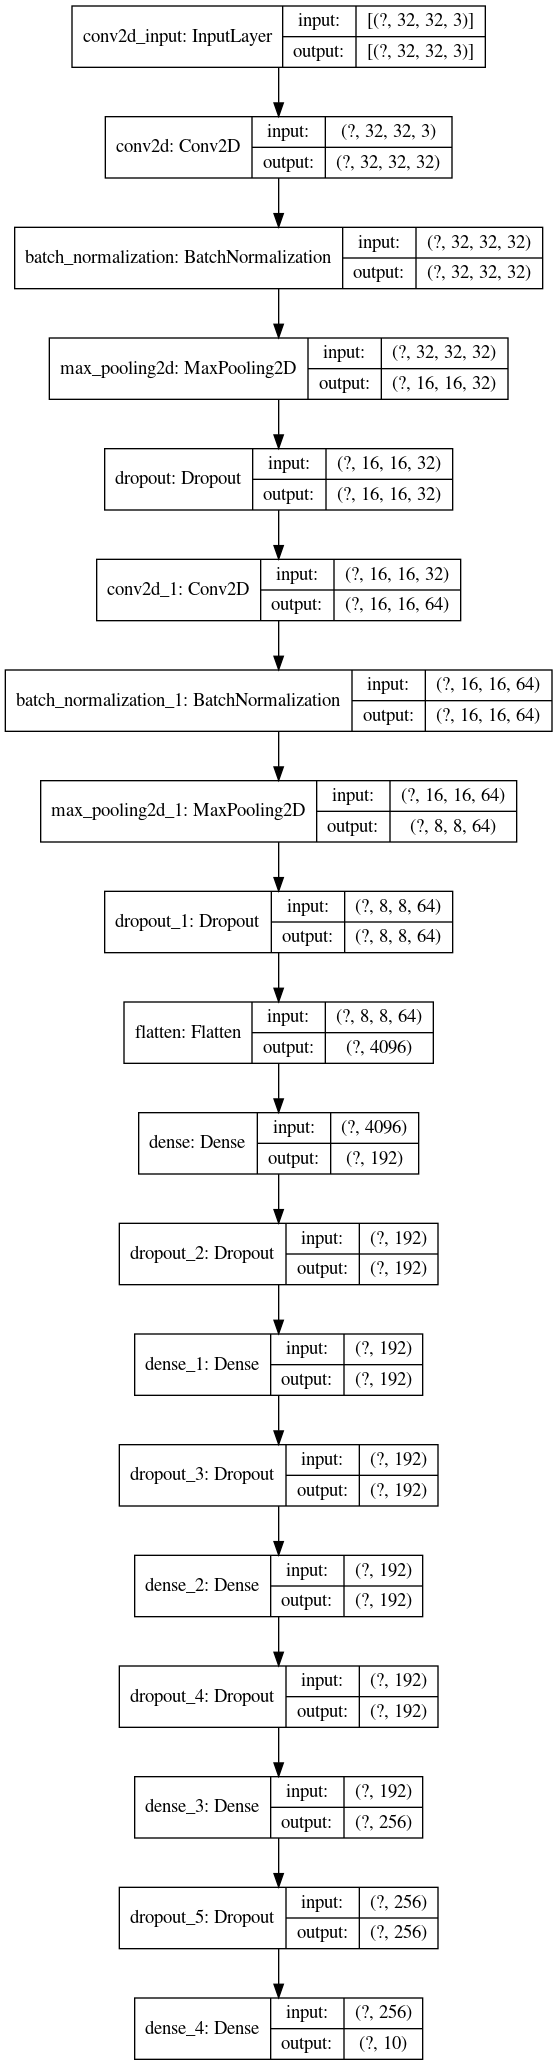

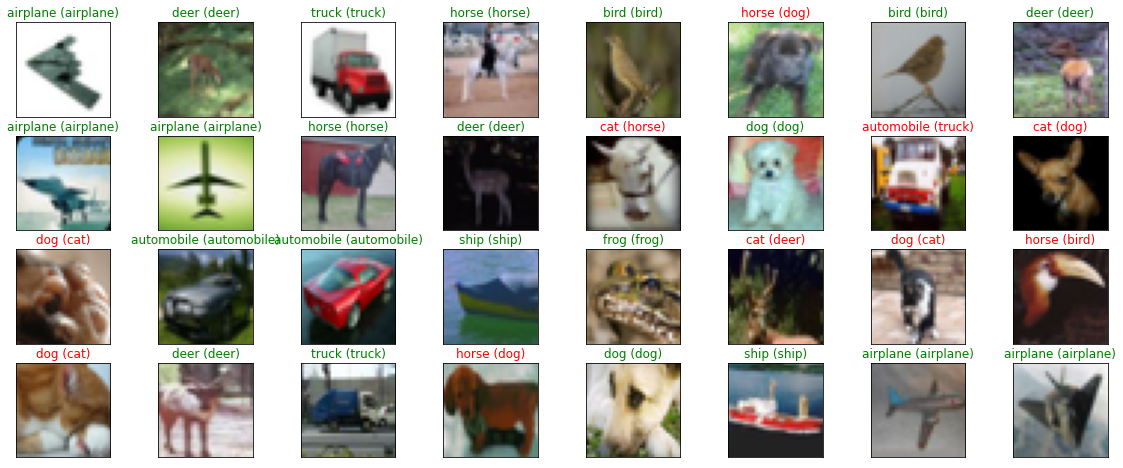

In [11]:

# As visualizações podem nos dar algumas dicas sobre por que a rede classifica erroneamente alguns objetos.
# obtendo previsões no conjunto de testes
y_hat = model.predict(x_test)

# definindo rótulos de texto (rótulos disponíveis na fonte original: https://www.cs.toronto.edu/~kriz/cifar.html)
cifar10_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# plot de amostra aleatória de imagens de teste, rótulos preditos e a "ground truth" advinda do dataset CIFAR-10
fig = plt.figure(figsize=(20, 8))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=32, replace=False)):
    ax = fig.add_subplot(4, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx = np.argmax(y_hat[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(cifar10_labels[pred_idx], cifar10_labels[true_idx]),
                 color=("green" if pred_idx == true_idx else "red"))
# amostras corretamente classificadas em verde, incorretamente classificadas em vermelho
print(model.summary())
plot_model(model, to_file='./data/cnn-CIFAR10.png', show_shapes=True, show_layer_names=True)